In [49]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow import keras
from functools import partial
import pickle


from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
)
from utils.utils import seed_everything

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import scipy.stats as stats


def draw_custom_pairplot(df):
    grd = sns.pairplot(
        df,
        kind="reg",
        corner=False,
        diag_kind="kde",
        plot_kws={
            "line_kws": {"color": "black"},
            "scatter_kws": {
                "alpha": 0.5,
            },
        },
    )

    def hide_plots(x, y, **kwargs):
        ax = plt.gca()
        ax.clear()
        ax.tick_params(
            axis="x",
            which="both",
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False,
        )
        ax.tick_params(
            axis="y",
            which="both",
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False,
        )
        ax.set_frame_on(True)

    num_comparisons = (len(df) ** 2) / 2

    def summary(x, y, **kwargs):
        correlation, pvalue = stats.pearsonr(x, y)
        corr_str = "%.3f" % round(correlation, 3)

        # Bonferroni correction
        corrected_pvalue = min(pvalue * num_comparisons, 1)
        pval_str = "%.3f" % round(corrected_pvalue, 3)
        label = f"corr: {corr_str}\np-val: {pval_str}"

        ax = plt.gca()
        ax.annotate(
            label,
            xy=(0.15, 0.4),
            size=20,
            xycoords=ax.transAxes,
            color="#440154",
        )

    sns.set(font_scale=2.5)

    grd = grd.map_upper(hide_plots)
    grd = grd.map_upper(summary)
    
    for ax in grd.axes.flatten():
        ax.set_xlabel(ax.get_xlabel(), rotation=30, fontsize=22)
        if ax.get_xlabel() == "width":
            ax.set_xlim(25, 270) 
        elif ax.get_xlabel() == "depth":
            ax.set_xlim(5.5, 10.5) 
        elif ax.get_xlabel() == "batch_size":
            ax.set_xlim(50, 300) 
        elif ax.get_xlabel() == "weight_decay":
            ax.set_xlim(0, 0.6) 
        elif ax.get_xlabel() == "learning_rate":
            ax.set_xlim(0, 0.1)
        elif ax.get_xlabel() == "num_epochs":
            ax.set_xlim(0, 21) 
        elif ax.get_xlabel() == "dropout":
            ax.set_xlim(0, 0.6) 
            
        ax.set_ylabel(
            ax.get_ylabel(),
            rotation=30,
            fontsize=22,
            labelpad=100,
            loc="bottom"
        )

    fig = plt.figure()
    fig.align_labels()
    plt.show()


In [51]:
protein_of_interest = "MDM2" 
other_protein = "12ca5"
top_k_size = 500 if protein_of_interest == "MDM2" else 1000
seq_check = (
    seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif
)

In [52]:
import json
import os
import pandas as pd
import seaborn as sns

f = f"{protein_of_interest}_hyperparam_output.csv"
if os.path.exists(f):
    SAVE_DF = pd.read_csv(f)
else:
    SAVE_DF = pd.DataFrame(
        columns=[
            "width",
            "depth",
            "batch_size",
            "weight_decay",
            "learning_rate",
            "num_epochs",
            "dropout",
            "combined_auc",
        ]
    )
SAVE_DF

,width,depth,batch_size,weight_decay,learning_rate,num_epochs,dropout,combined_auc
0,512.0,7.0,64.0,0.25,0.00534,13.0,0.19,0.028003
1,256.0,7.0,256.0,0.34,0.00018,6.0,0.16,0.020684
2,256.0,9.0,256.0,0.16,0.01540,1.0,0.42,0.021321
3,256.0,7.0,32.0,0.44,0.00077,6.0,0.32,0.024741
4,256.0,7.0,128.0,0.02,0.09297,12.0,0.12,0.024901
5,128.0,8.0,128.0,0.09,0.00053,3.0,0.10,0.023628


6


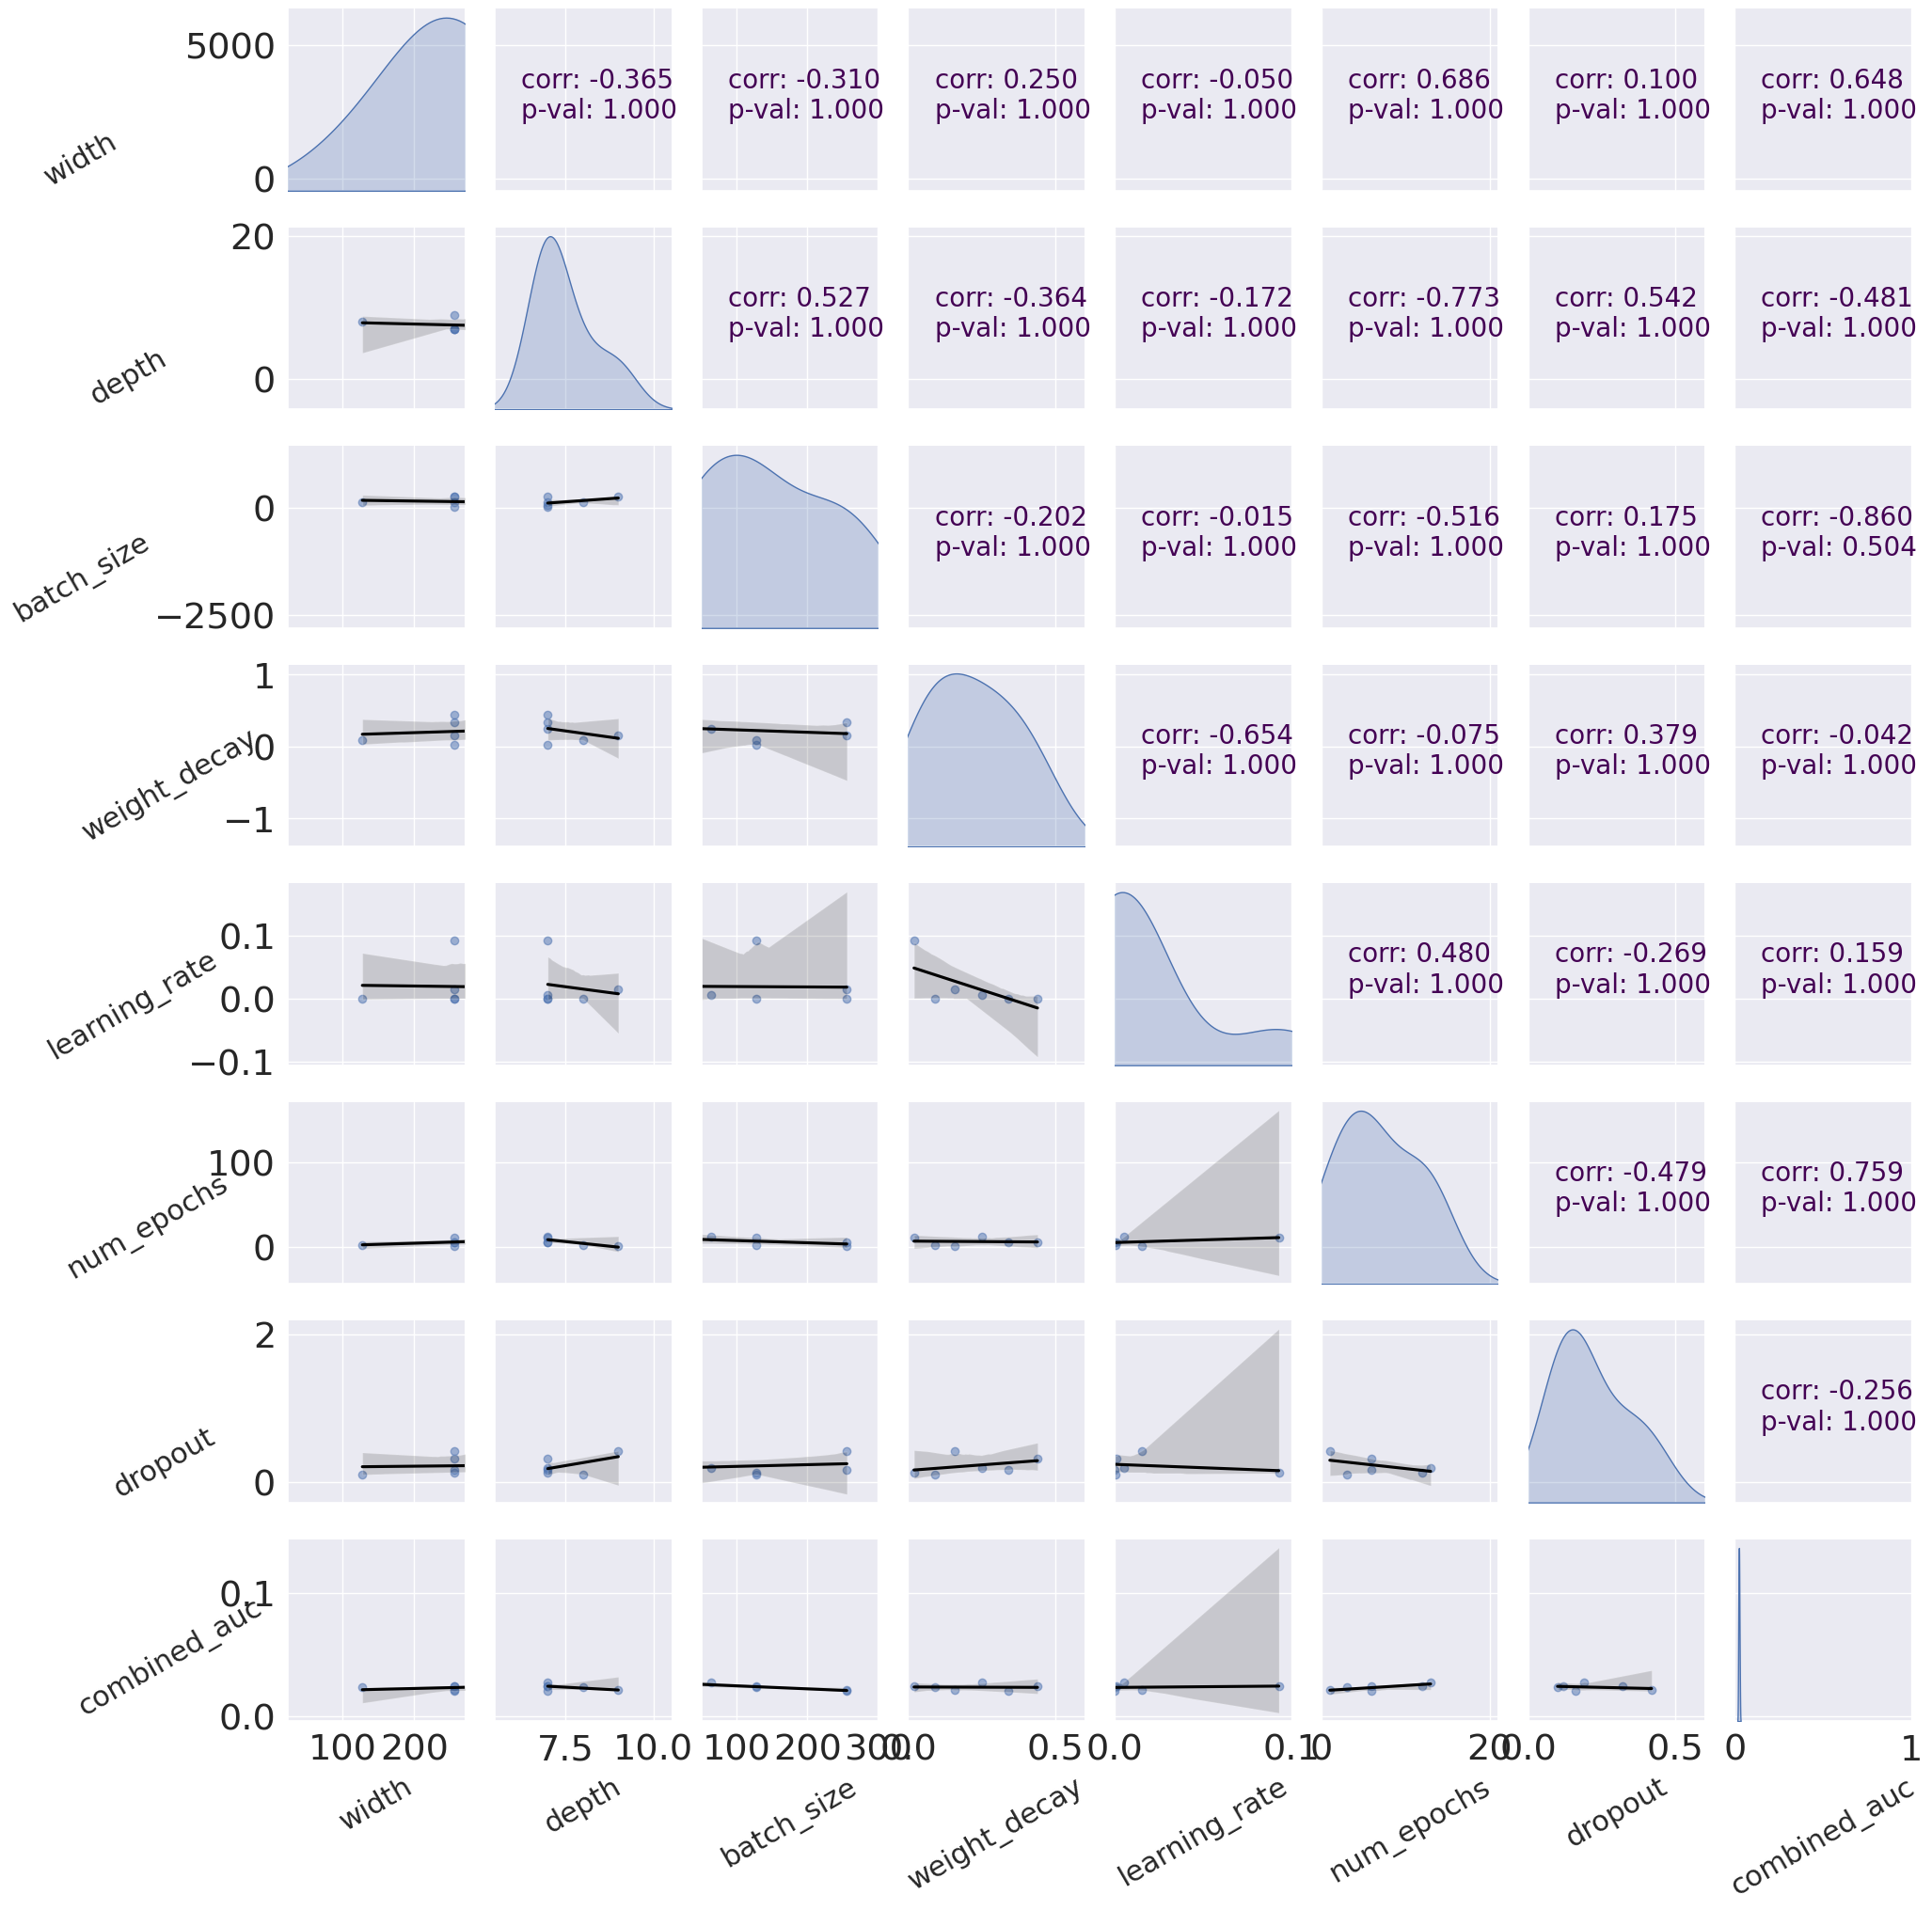

<Figure size 640x480 with 0 Axes>

In [53]:
deduped_df = SAVE_DF.drop_duplicates(subset=['width', 'depth', 'batch_size', 'weight_decay', 'learning_rate', 'num_epochs', 'dropout'])
print(len(deduped_df))
draw_custom_pairplot(deduped_df)

## Let's Do Hyperparam Optimization!

In [19]:
seed_everything(0)

X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile=f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-R3.csv",
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)
(X_holdout, X, y_holdout, y_raw, peptides_eval, peptides) = train_test_split(
    X,
    y_raw,
    peptides,
    test_size=0.8,
    shuffle=True,
    random_state=5,
)
print(len(X))

with open("X_holdout.pkl", "wb") as pickle_file:
    pickle.dump(X_holdout, pickle_file)
with open("y_holdout.pkl", "wb") as pickle_file:
    pickle.dump(y_holdout, pickle_file)

def pval_filter_ranking_lambda(x):
    return x[1] + x[2]


2023-06-01 11:35:43.438354: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


26329


In [18]:
def objective_func(args):
    global SAVE_DF
    seed_everything(0)

    args = {
        "width": int(args['width']),
        "depth": int(args['depth']),
        "batch_size": int(args['batch_size']),
        "weight_decay": round(args["weight_decay"], 2),
        "learning_rate": round(args["learning_rate"], 5),
        "num_epochs": int(args['num_epochs']),
        "dropout": round(args["dropout"], 2),
    }

    def benchmark(result, peptides, ranking_lambda):

        y_pred = result.y_pred_rescaled
        y_true = result.y_test
        # Check that the cross folds experiment returns our y_true in the same order as before
        # assert (y_true == y_raw).all()
        mdm2_ordering = [ranking_lambda(pred) for pred in y_pred]
        result = plot_ratio_by_ranking(
            peptides=peptides,
            y_rankings=[(mdm2_ordering, "y_pred", "red")],
            title="",
            hit_rate_func=seq_check,
            peptide_dataset_size=top_k_size,
            plot=False,
            save_file=None,
        )
        return result


    _, mdm2_results = experiment.Experiment().run_adhoc_experiment(
        X,
        y_raw,
        partial(
            rnn.ThreeChannelRegressionRNN_gelu,
            depth=args["depth"],
            width=args["width"],
            dropout=args["dropout"],
            # activation_func=activation
        ),
        model_save_name=f"grid_search_models_2/learning_rate({args['learning_rate']})_dropout({args['dropout']})_batch_size({args['batch_size']})_depth({args['depth']})_width({args['width']})_weightdecay({args['weight_decay']}).h5",
        normalize=True,
        batch_size=args["batch_size"],
        optimizer=partial(
            keras.optimizers.Adam,
            learning_rate=args["learning_rate"],
            weight_decay=args["weight_decay"],
        )(),
        num_epochs=args["num_epochs"],
    )

    combined_auc = benchmark(mdm2_results, peptides, pval_filter_ranking_lambda)

    series = pd.Series(
        {
            "width": args['width'],
            "depth": args['depth'],
            "batch_size": args['batch_size'],
            "weight_decay": args['weight_decay'],
            "learning_rate": args['learning_rate'],
            "num_epochs": args['num_epochs'],
            "dropout": args['dropout'],
            "combined_auc": combined_auc,
        }
    )
    SAVE_DF = SAVE_DF.append(series, ignore_index=True)
    SAVE_DF.to_csv(f, index=False)
    print("Hey Yitong! Finished! ", len(SAVE_DF))
    return 1 - combined_auc


In [13]:
from hyperopt import hp

space = {
    "width": hp.choice("width", [32, 64, 128, 256]),
    "depth": hp.choice("depth", [6, 7, 8, 9, 10]),
    "batch_size": hp.choice("batch_size", [32, 64, 128, 256]),
    "weight_decay": hp.choice("weight_decay", [0.0, 0.001, 0.01, 0.05, 0.1]),
    "learning_rate": hp.choice("learning_rate", [0.1, 0.01, 0.001, 0.0001]),
    "num_epochs": hp.choice("num_epochs", [1, 3, 5, 10, 15, 20]),
    "dropout": hp.choice("dropout", [0.0, 0.001, 0.01, 0.05, 0.1]),
}


# minimize the objective over the space
from hyperopt import fmin, tpe, rand
best = fmin(objective_func, space, algo=rand.suggest, max_evals=100) # algo=tpe.suggest, max_evals=100)


Epoch 1/3                                              

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2023-05-31 22:21:50.964593: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


  0%|          | 0/100 [00:14<?, ?trial/s, best loss=?]


KeyboardInterrupt: 